In [75]:
from __future__ import annotations

import itertools

import ensaio
import harmonica as hm
import numpy as np
import pandas as pd
import pyproj
import verde as vd
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import optuna

from invert4geom import optimization

In [2]:
fname = ensaio.fetch_bushveld_gravity(version=1)
data = pd.read_csv(fname)

projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)

coordinates = (easting, northing, data.height_geometric_m.values)

In [64]:
num = 5

damp_lower = -30
damp_upper = 2
dampings = np.logspace(damp_lower, damp_upper, num)

depth_lower = 100
depth_upper = 100e3
depths = np.linspace(depth_lower, depth_upper, num)

dampings, depths

(array([1.e-30, 1.e-22, 1.e-14, 1.e-06, 1.e+02]),
 array([   100.,  25075.,  50050.,  75025., 100000.]))

## Standard CV

In [65]:
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

Number of combinations: 25
Combinations: [{'damping': np.float64(1e-30), 'depth': np.float64(100.0)}, {'damping': np.float64(1e-30), 'depth': np.float64(25075.0)}, {'damping': np.float64(1e-30), 'depth': np.float64(50050.0)}, {'damping': np.float64(1e-30), 'depth': np.float64(75025.0)}, {'damping': np.float64(1e-30), 'depth': np.float64(100000.0)}, {'damping': np.float64(1e-22), 'depth': np.float64(100.0)}, {'damping': np.float64(1e-22), 'depth': np.float64(25075.0)}, {'damping': np.float64(1e-22), 'depth': np.float64(50050.0)}, {'damping': np.float64(1e-22), 'depth': np.float64(75025.0)}, {'damping': np.float64(1e-22), 'depth': np.float64(100000.0)}, {'damping': np.float64(1e-14), 'depth': np.float64(100.0)}, {'damping': np.float64(1e-14), 'depth': np.float64(25075.0)}, {'damping': np.float64(1e-14), 'depth': np.float64(50050.0)}, {'damping': np.float64(1e-14), 'depth': np.float64(75025.0)}, {'damping': np.float64(1e-14), 'depth': np.float64(100000.0)}, {'damping': np.float64(1e-06), 

  0%|          | 0/25 [00:00<?, ?it/s]

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=5.0225e-17): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.77171e-17): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=6.8227e-17): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=7.62912e-17): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=5.9832e-17

Best score: 0.8802087042656341
Best parameters: {'damping': np.float64(1e-06), 'depth': np.float64(25075.0)}


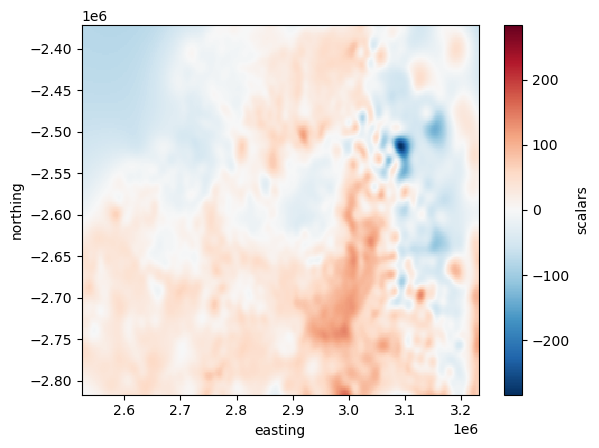

In [66]:
equivalent_sources = hm.EquivalentSources()

scores = []
for params in tqdm(parameter_sets):
    equivalent_sources.set_params(**params, block_size=20e3,)
    score = np.mean(
        vd.cross_val_score(
            equivalent_sources,
            coordinates,
            data.gravity_disturbance_mgal,
        )
    )
    scores.append(score)

best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

eqs_best = hm.EquivalentSources(**parameter_sets[best]).fit(
    coordinates, data.gravity_disturbance_mgal
)
# Define grid coordinates
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=2e3,
    extra_coords=2.5e3,
)

grid_search_result = eqs_best.grid(grid_coords)
grid_search_result.scalars.plot()

In [67]:
def plot_cv_scores(
    scores: list[float],
    parameters: list[float],
    logx: bool = False,
    logy: bool = False,
    x_title: str = "parameter value",
) -> typing.Any:
    """
    plot a graph of cross-validation scores vs hyperparameter values

    Parameters
    ----------
    scores : list[float]
        score values
    parameters : list[float]
        parameter values
    logx, logy : bool, optional
        make the x or y axes log scale, by default False
    """
    figsize = (5, 3.5)

    df0 = pd.DataFrame({"scores": scores, "parameters": parameters})
    df = df0.sort_values(by="parameters")

    best = df.scores.argmax()

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df.parameters, df.scores, marker="o")
    ax.plot(
        df.parameters.iloc[best],
        df.scores.iloc[best],
        "s",
        markersize=10,
        color='r',
        label=f"Best score: {round(df.scores.iloc[best],3)}",
    )
    ax.legend(loc="best")
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    ax.set_xlabel(x_title)
    ax.set_ylabel("Score ")

    plt.tight_layout()

In [68]:
df = pd.DataFrame(parameter_sets)
df["score"]=scores
df = df.sort_values("score", ascending=False)
df

,damping,depth,score
16,1.000000e-06,25075.0,0.880209
6,1.000000e-22,25075.0,0.880209
1,1.000000e-30,25075.0,0.880209
11,1.000000e-14,25075.0,0.880209
18,1.000000e-06,75025.0,0.878171
17,1.000000e-06,50050.0,0.876939
7,1.000000e-22,50050.0,0.876438
2,1.000000e-30,50050.0,0.876438
12,1.000000e-14,50050.0,0.876438
8,1.000000e-22,75025.0,0.872062


In [69]:
damping_df = df.sort_values(["damping", "score"])
damping_df = damping_df.drop_duplicates("damping", keep="last")

depth_df = df.sort_values(["depth", "score"])
depth_df = depth_df.drop_duplicates("depth", keep="last")

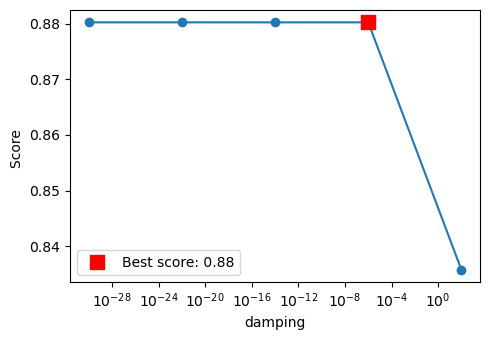

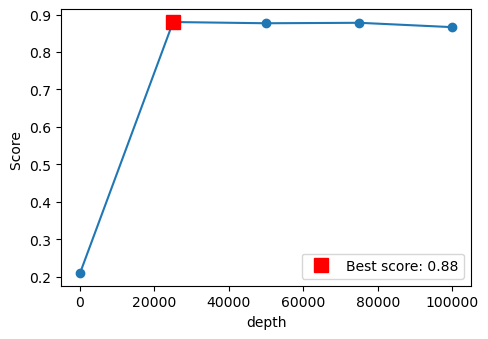

In [70]:
plot_cv_scores(
    scores=damping_df.score,
    parameters=damping_df.damping,
    logx=True,
    x_title="damping",
)

plot_cv_scores(
    scores=depth_df.score,
    parameters=depth_df.depth,
    x_title="depth",
)

## Optimization

In [82]:
study, eqs = optimization.optimize_eq_source_params(
    coordinates,
    data.gravity_disturbance_mgal,
    n_trials=10,
    damping_limits=(10**damp_lower, 10**damp_upper),
    depth_limits=(depth_lower, depth_upper),
    # damping=None,
    # depth="default",
    block_size=20e3,
    plot=True,
    # sampler=optuna.integration.BoTorchSampler(n_startup_trials=4)
)

  0%|          | 0/10 [00:00<?, ?it/s]

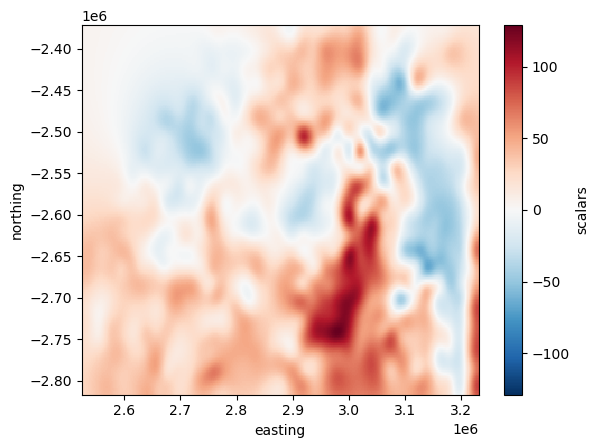

In [83]:
optimization_result = eqs.grid(grid_coords)
optimization_result.scalars.plot()

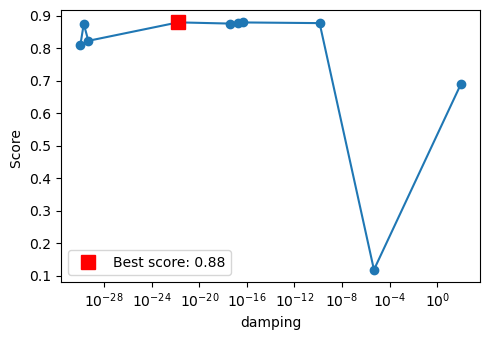

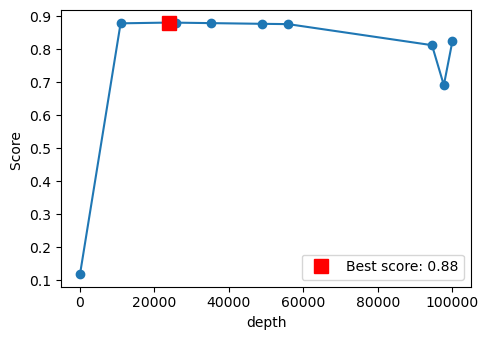

In [84]:
study_df = study.trials_dataframe()

damping_df = study_df.sort_values("params_damping")
plot_cv_scores(
    scores=damping_df.value,
    parameters=damping_df.params_damping,
    logx=True,
    x_title="damping",
)

depth_df = study_df.sort_values("params_depth")
plot_cv_scores(
    scores=depth_df.value,
    parameters=depth_df.params_depth,
    x_title="depth",
)

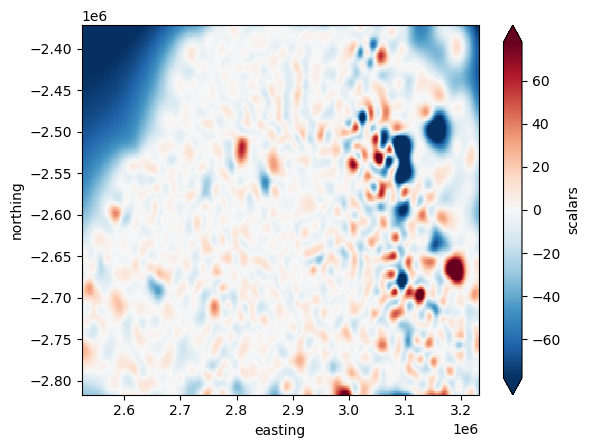

In [85]:
(grid_search_result.scalars - optimization_result.scalars).plot(robust=True)